### import libraries

In [13]:
import os
from PIL import Image
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import xml.etree.ElementTree as ET
import datetime

### Load and preprocess data

In [15]:
class ImageDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.images, self.labels = self._load_images()

    def _load_images(self):
        images = []
        labels = []
        class_names = ['adults', 'children']
        
        for label, class_name in enumerate(class_names):
            class_dir = os.path.join(self.root_dir, class_name)
            class_aug_dir = f"{class_dir}_aug"
            if os.path.isdir(class_dir):
                for img_name in os.listdir(class_dir):
                    if img_name.endswith(('.jpg')):
                        images.append(os.path.join(class_dir, img_name))
                        labels.append(label)
            if os.path.isdir(class_aug_dir):
                for img_name in os.listdir(class_aug_dir):
                    if img_name.endswith(('.jpg')):
                        images.append(os.path.join(class_aug_dir, img_name))
                        labels.append(label)
        
        return images, labels
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        img_path = self.images[idx]
        name_splits = os.path.splitext(img_path)[0].split('\\')
        filename = name_splits[len(name_splits)-1]
        dir_name = name_splits[len(name_splits)-2]
        file_parts = filename.split('_')
        dir_parts = dir_name.split('_')
        if '_' in filename:
            xml_name = f'{name_splits[0]}\\{dir_parts[0]}\\{file_parts[0]}.xml'
        else:
            xml_name = f'{os.path.splitext(img_path)[0]}.xml'
        if os.path.exists(xml_name):
            tree = ET.parse(xml_name)
            root = tree.getroot()
            bndbox = root.find('object').find('bndbox')
            xmin = int(bndbox.find('xmin').text)
            ymin = int(bndbox.find('ymin').text)
            xmax = int(bndbox.find('xmax').text)
            ymax = int(bndbox.find('ymax').text)
            image = Image.open(img_path).convert("RGB")
            width, height = image.size
            w = xmax-xmin
            h = ymax-ymin
            if len(file_parts) > 1:
                if file_parts[1] == '90':
                    ymin = xmin
                    xmin = width - ymax
                    xmax = xmin + h
                    ymax = ymin + w
                elif file_parts[1] == '180':
                    xmax = width - xmin
                    ymax = height - ymin
                    xmin = xmax - w
                    ymin = ymax - h
                elif file_parts[1] == '270':
                    xmin = ymin
                    ymin = height - xmin - w
                    xmax = xmin + h
                    ymax = ymin + w
                elif file_parts[1] == 'hflip':
                    xmin = width - xmin - w
                    ymin = ymin
                    xmax = xmin + w
                    ymax = ymax
                elif file_parts[1] == 'vflip':
                    xmin = xmin
                    ymin = height - ymin - h
                    xmax = xmax
                    ymax = ymin + h
            image = image.crop([xmin, ymin, xmax, ymax])
        else:
            image = Image.open(img_path).convert("RGB")
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

In [16]:
# Define transformations for the training and test sets
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_root_dir = '../FPdataset/train'
trainset = ImageDataset(root_dir = train_root_dir, transform = transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,shuffle=True)

test_root_dir = '../FPdataset/test'
testset = ImageDataset(root_dir = test_root_dir, transform = transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4, shuffle=True)

# Define class names
classes = ('adult', 'child')

### visualize the data

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


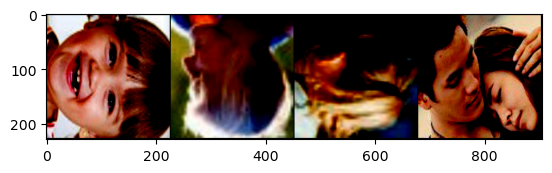

child adult child adult


In [17]:
# Function to display images
def imshow(img):
    # img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# Show images and labels
imshow(torchvision.utils.make_grid(images))
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

### define ResNet

In [18]:
class BasicBlock(nn.Module):
    expansion = 1  # No expansion in the basic block

    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample

    def forward(self, x):
        identity = x

        if self.downsample is not None:
            identity = self.downsample(x)

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        out += identity
        out = self.relu(out)

        return out

class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=1000):
        super(ResNet, self).__init__()
        self.in_channels = 64
        
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

    def _make_layer(self, block, out_channels, blocks, stride=1):
        downsample = None
        if stride != 1 or self.in_channels != out_channels * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels * block.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels * block.expansion),
            )

        layers = []
        layers.append(BasicBlock(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels * block.expansion
        for _ in range(1, blocks):
            layers.append(BasicBlock(self.in_channels, out_channels))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x


net = ResNet(BasicBlock, [2, 2, 2, 2], 2)

### define loss function and optimizer

In [19]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

### train the model

In [20]:
num_epochs = 20
best_acc = 0
best_net = net
for epoch in range(num_epochs):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    if (100 * correct / total) > best_acc:
        best_net = net
    print(f'Epoch{epoch + 1}, Loss: {round(running_loss/len(trainloader), 5)}     Accuracy = {round(100 * correct / total, 5)} %')
print('Finished Training')

KeyboardInterrupt: 

In [14]:
timestamp = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
model_base_name = 'resnet34'
file_extension = '.pth'
model_file_name = f"./models/{model_base_name}_{timestamp}{file_extension}"

torch.save(net.state_dict(), model_file_name)

### evaluate the model

In [10]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on test images: {100 * correct / total} %')

Accuracy of the network on the 10000 test images: 59.166666666666664 %


### view the result

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


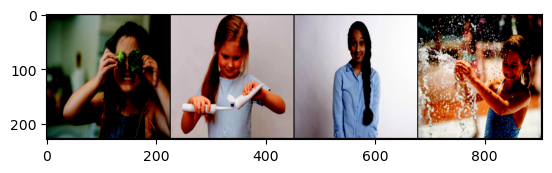

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


adult adult adult adult


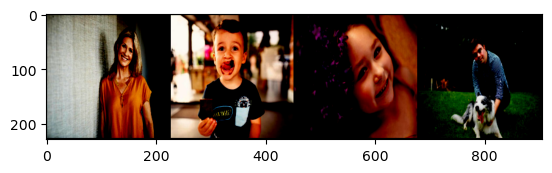

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


adult child adult child


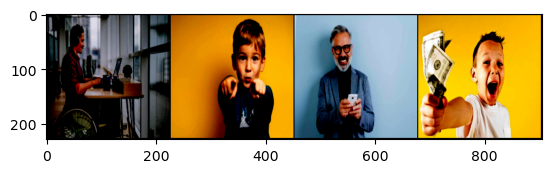

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


adult adult child child


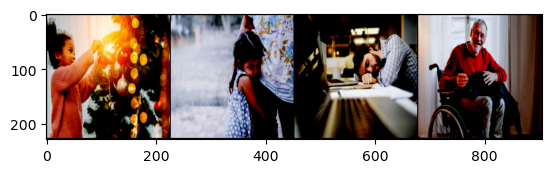

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


child child adult adult


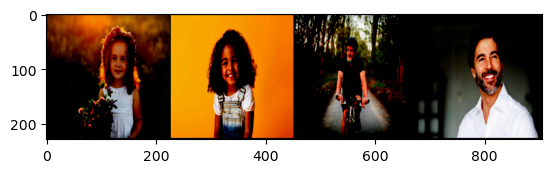

child child adult child
Accuracy of adult : 56.666666666666664 %
Accuracy of child : 51.666666666666664 %


In [12]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
a = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        if a < 5:
            imshow(torchvision.utils.make_grid(images))
            print(' '.join(f'{classes[predicted[j]]:5s}' for j in range(4)))
            a+=1
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

for i in range(2):
    print(f'Accuracy of {classes[i]} : {100 * class_correct[i] / class_total[i]} %')